# Importance sampling with feedforward neural networks

In [1]:
import sys
import time

import pandas as pd

import numpy as np
from numpy import savetxt, loadtxt

import matplotlib.pyplot as plt

from scipy import integrate
from scipy.stats import norm

from tqdm.notebook import trange
from cycler import cycler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import initializers, optimizers, layers, regularizers
from tensorflow.keras.layers import Input, Dense, Lambda, Add, Subtract, Multiply, Concatenate, Minimum, Maximum
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.backend as K

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
 
print('Python version: ', sys.version)
print('Tensorflow version: ', tf.__version__)
print('Keras version: ', keras.__version__)

np.random.seed(2023)
tf.random.set_seed(2023)


2023-06-02 13:35:25.445843: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Python version:  3.10.4 (main, Mar 31 2022, 03:38:35) [Clang 12.0.0 ]
Tensorflow version:  2.10.0
Keras version:  2.10.0


In [2]:
N_train = 250       # Number of time steps for training
N_test = 250        # Number of time steps for testing

################################################################################

n_hidden = 1          # Number of hidden layers for deep neural network
n_nodes = 2           # Number of nodes in hidden layers
batchsize = 1024      # Batch size
learningrate = 1.0e-3 # Learning rate for Adam (standard 1e-3)

N_NN_train = int(2 * 100 * batchsize) # Size of training data set for neural network
N_NN_test = int(1.0e5)                # Size of testing data set for neural network

################################################################################
##### Further model parameters

T = 1                 # Terminal time

X0 = 50               # Initial price of asset
mu = 0.05             # Interest rate

strike = 70           # Strike for the call option
sigma = 0.20          # Volatility
barrier_upper = 90

barrier_lower = 40

################################################################################

delta_t_train = T/N_train         # Time increments for training
delta_t_test = T/N_test           # Time increments for testing

t_train = np.linspace(0, T, N_train+1)
t_test = np.linspace(0, T, N_test+1)


In [3]:
def func_lower(x):
    greater = K.greater_equal(x, barrier_lower)
    greater = K.cast(greater, dtype=K.floatx())   
    return greater

def func_upper(x):
    lower = K.less_equal(x, barrier_upper)
    lower = K.cast(lower, dtype=K.floatx())    
    return lower

## Plotting sample path

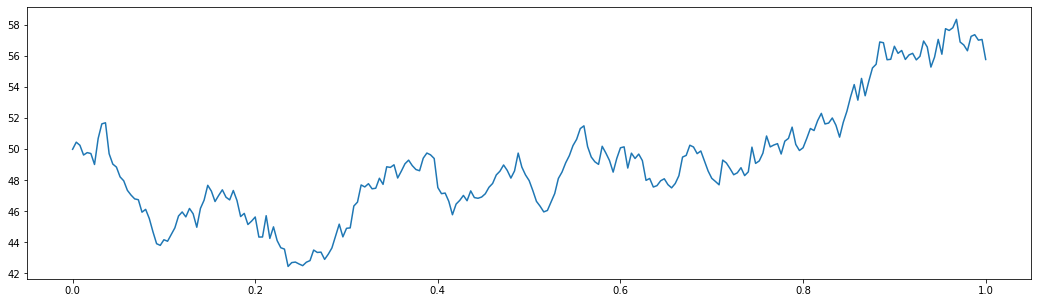

In [4]:
M = np.sqrt(delta_t_test) * np.random.normal(0, 1, (N_test))
M = np.concatenate([np.zeros((1)), M])
M = np.cumsum(M)
A = (mu - sigma**2 / 2) * t_test
X = X0 * np.exp(A + sigma * M)

plt.figure(figsize=(18, 5))

plt.plot(t_test, np.transpose(X))

plt.show()


## Computing option price

In [5]:
start_time = time.time()

M = np.sqrt(delta_t_test) * np.random.normal(0, 1, (N_NN_test, N_test))
M = np.concatenate([np.zeros((N_NN_test, 1)), M], axis = 1)
M = np.cumsum(M, axis = 1)
A = (mu - sigma**2 / 2) * t_test
X = X0 * np.exp(A + sigma * M)

# Compute arithmetic average call option
average = np.sum(X[:, :N_test] * delta_t_test, axis=1)/T
payoffs = 100*np.clip(average-strike, 0, None)

# Count cases where call option is positive
condition_call = (average-strike >= 0)*1
counter_call = np.sum(condition_call)

# Calculate non-violations of barrier
condition_1 = (X.min(axis=1) >= barrier_lower)*1
condition_2 = (X.max(axis=1) <= barrier_upper)*1
condition_barrier = np.multiply(condition_1, condition_2)
counter_barrier = np.sum(condition_barrier)

# Update payoff to reflect barrier option
payoffs = payoffs * condition_barrier

# Calculate positive fraction
counter_both = np.sum(np.multiply(condition_call, condition_barrier))

mean_mc = np.mean(payoffs)
var_mc = np.var(payoffs)
stderr_mc = np.std(payoffs) / np.sqrt(N_NN_test)
second_moment_mc = np.mean(np.power(payoffs, 2))

elapsed_time = time.time() - start_time

print("Computing time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

print("========================================")

print("Mean (MC): ", np.around(mean_mc, 4))
print("Second moment (MC): ", np.around(second_moment_mc, 4))
print("Variance (MC): ", np.around(var_mc, 4))

print("========================================")

print("Standard error (MC): ", np.around(stderr_mc, 4), " (", np.around(stderr_mc / mean_mc * 100, 2), "% )")

print("========================================")

print("Probability of positive call option (MC): ", str(np.around(counter_call / N_NN_test * 100, 4)))
print("Probability of non-knock-out (MC): ", str(np.around(counter_barrier/N_NN_test * 100, 4)))
print("Probability of positive payoff (MC): ", str(np.around(counter_both / N_NN_test * 100, 8)))


Computing time:  00:00:01
Mean (MC):  0.2322
Second moment (MC):  61.3011
Variance (MC):  61.2472
Standard error (MC):  0.0247  ( 10.66 % )
Probability of positive call option (MC):  0.365
Probability of non-knock-out (MC):  78.824
Probability of positive payoff (MC):  0.148


## Input data for NN training

In [6]:
xtrain = ([np.zeros((N_NN_train))] + # t_0
          [X0*np.ones((N_NN_train))] + # X_0
          [np.min(X0) * np.ones((N_NN_train))] + 
          [np.max(X0) * np.ones((N_NN_train))] + 
          [np.zeros((N_NN_train))] + # initial value of the payoff
          [np.zeros((N_NN_train))] + # initial value of the first part of the stoch exp
          [np.zeros((N_NN_train))] + # initial value of the second part of the stoch exp
          [np.random.normal(0, 1, (N_NN_train)) for i in range(N_train)]) # increments N(0,1)

ytrain = np.zeros((N_NN_train))

## Generating neural network

In [7]:
layers = []

layers += [Dense(n_nodes, activation='tanh', trainable=True, input_shape=(1, ))]

for i in range(n_hidden-1):
    layers += [Dense(n_nodes, activation='tanh', trainable=True)]

layers += [Dense(1, activation='linear', trainable=True)]


In [8]:
t_0 = Input(shape=(1, ))
X_0 = Input(shape=(1, ))

X_min = Input(shape=(1, ))
X_max = Input(shape=(1, ))
 
c_0 = Input(shape=(1, ))
c_1 = Input(shape=(1, ))
c_2 = Input(shape=(1, ))
 
inputs = [t_0]+[X_0]+[X_min]+[X_max]+[c_0]+[c_1]+[c_2]

t_current = t_0
X_current = X_0

for j in range(N_train):
    
    c_0_helper = X_current * delta_t_train
    c_0 = Add()([c_0, c_0_helper])
    
    strategy = t_current
    for i in range(n_hidden+1):
        strategy = layers[i](strategy)
    
    incr_B = Input(shape=(1, ))
    inputs = inputs + [incr_B]
    
    incr_M = np.sqrt(delta_t_train) * incr_B
    
    helper_e1 = Multiply()([strategy, incr_M])
    c_1 = Add()([c_1, helper_e1])
    
    helper_e2 = Multiply()([strategy, strategy]) * delta_t_train
    c_2 = Add()([c_2, helper_e2])
    
    t_current = t_current + delta_t_train
    
    helper_drift = mu * X_current * delta_t_train
    helper_diffusion = sigma * Multiply()([X_current, incr_M])
    
    helper_X = Add()([helper_drift, helper_diffusion])
    X_current = Add()([X_current, helper_X])
    
    X_min = Minimum()([X_min, X_current])
    X_max = Maximum()([X_max, X_current])

helper_e5 = -0.5 * c_1
helper_e6 = 0.25 * c_2

helper_e7 = Add()([helper_e5, helper_e6])
helper_e8 = Lambda(lambda x: K.exp(x))(helper_e7)

payoff = 100 * Lambda(lambda x: K.relu(x-strike))(c_0)

payoff_adjusted = Multiply()([payoff, helper_e8])

X_min = Lambda(lambda x: func_lower(x))(X_min)
X_max = Lambda(lambda x: func_upper(x))(X_max)

helper_knockout = Multiply()([X_min, X_max])
payoff_final = Multiply()([payoff_adjusted, helper_knockout])

outputs = [payoff_final]


2023-06-02 13:35:34.989456: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
opt = optimizers.Adam(learning_rate = learningrate)
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=opt, loss='mean_squared_error')


In [10]:
indices_list = []

for i in range(len(model.layers)):
    layer_train_size = len(model.layers[i].get_weights())
    if layer_train_size > 0:
        indices_list += [i]

## Training the neural network

In [11]:
early_stopping_callback = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              verbose=1, 
                              patience=1, 
                              restore_best_weights=True)

In [12]:
start_time = time.time()

history = model.fit(x=xtrain,
                    y=ytrain,
                    epochs=1000,
                    verbose=1,
                    shuffle=True,
                    batch_size=batchsize,
                    validation_split=0.5,
                    callbacks=[early_stopping_callback])

elapsed_time = time.time() - start_time

Epoch 1/1000
100/100 [==============================] - 56s 189ms/step - loss: 47.2270 - val_loss: 43.5469
Epoch 2/1000
100/100 [==============================] - 4s 37ms/step - loss: 35.5537 - val_loss: 33.5288
Epoch 3/1000
100/100 [==============================] - 4s 37ms/step - loss: 28.0529 - val_loss: 27.4531
Epoch 4/1000
100/100 [==============================] - 4s 37ms/step - loss: 23.0798 - val_loss: 22.8528
Epoch 5/1000
100/100 [==============================] - 4s 36ms/step - loss: 19.4929 - val_loss: 19.6452
Epoch 6/1000
100/100 [==============================] - 3s 35ms/step - loss: 16.8043 - val_loss: 17.0773
Epoch 7/1000
100/100 [==============================] - 4s 36ms/step - loss: 14.7043 - val_loss: 14.9633
Epoch 8/1000
100/100 [==============================] - 4s 36ms/step - loss: 13.0024 - val_loss: 13.3346
Epoch 9/1000
100/100 [==============================] - 4s 35ms/step - loss: 11.6432 - val_loss: 11.9386
Epoch 10/1000
100/100 [==============================

100/100 [==============================] - 3s 35ms/step - loss: 0.5019 - val_loss: 0.5442
Epoch 80/1000
100/100 [==============================] - 3s 35ms/step - loss: 0.4917 - val_loss: 0.5338
Epoch 81/1000
100/100 [==============================] - 4s 35ms/step - loss: 0.4820 - val_loss: 0.5232
Epoch 82/1000
100/100 [==============================] - 4s 36ms/step - loss: 0.4730 - val_loss: 0.5129
Epoch 83/1000
100/100 [==============================] - 3s 35ms/step - loss: 0.4642 - val_loss: 0.5035
Epoch 84/1000
100/100 [==============================] - 4s 35ms/step - loss: 0.4559 - val_loss: 0.4952
Epoch 85/1000
100/100 [==============================] - 3s 35ms/step - loss: 0.4483 - val_loss: 0.4867
Epoch 86/1000
100/100 [==============================] - 3s 34ms/step - loss: 0.4409 - val_loss: 0.4790
Epoch 87/1000
100/100 [==============================] - 4s 35ms/step - loss: 0.4342 - val_loss: 0.4711
Epoch 88/1000
100/100 [==============================] - 4s 35ms/step - loss: 

In [13]:
model_best = keras.Sequential()
model_best.add(Dense(n_nodes, activation='tanh', input_shape=(1, )))

for i in range(n_hidden-1):
    model_best.add(Dense(n_nodes, activation='tanh'))

model_best.add(Dense(1, activation='linear'))
model_best.build()

count = 0
for j in indices_list:
    model_best.layers[count].set_weights(model.layers[j].get_weights())
    count += 1


## Some visualizations

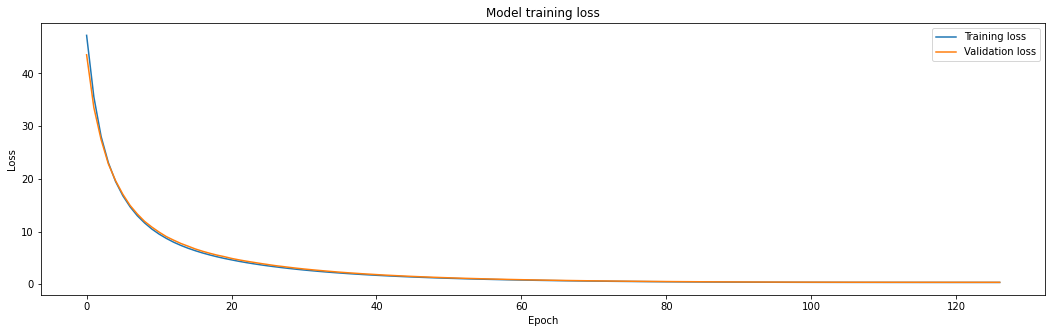

In [14]:
plt.figure(figsize=(18, 5))

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')

plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
# plt.yscale('log')

plt.show()

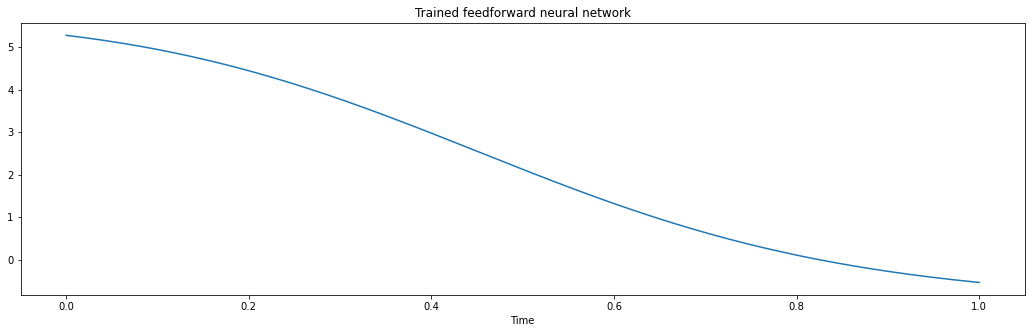

In [15]:
learnedstrat = model_best.predict(t_test, verbose = 0)

plt.figure(figsize=(18, 5))
plt.plot(t_test, learnedstrat)
plt.title("Trained feedforward neural network")
plt.xlabel("Time")
plt.show()


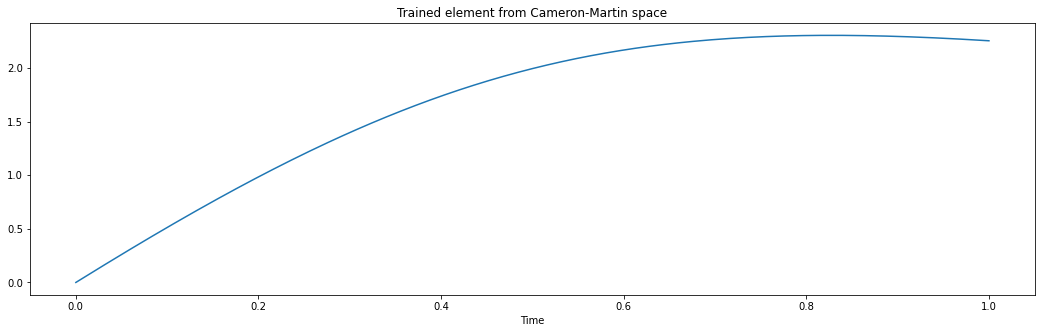

In [16]:
# Visualizing the drift

normdrift = 0
driftdummy = np.zeros((1))
drift = np.zeros((N_test+1))
driftdelta = np.zeros((N_test))

for j in range(N_test):
    normdrift += learnedstrat[j]**2 * delta_t_test
    driftdelta[j] = learnedstrat[j] * delta_t_test
    driftdummy += learnedstrat[j] * delta_t_test
    drift[j+1] = driftdummy

plt.figure(figsize=(18, 5))

plt.plot(t_test, drift)
plt.title("Trained element from Cameron-Martin space")
plt.xlabel("Time")
plt.show()


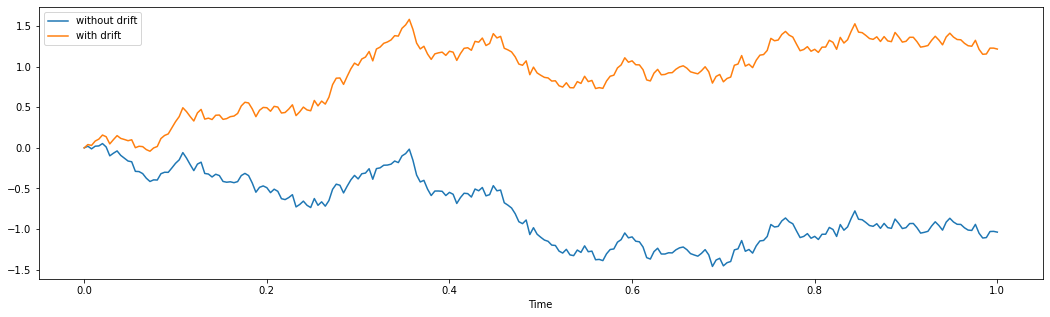

In [17]:
M = np.sqrt(delta_t_test) * np.random.normal(0, 1, (N_test))

M_MC = np.cumsum(np.concatenate([np.zeros((1)), M]))
M_IS = np.cumsum(np.concatenate([np.zeros((1)), M + driftdelta]))

plt.figure(figsize=(18, 5)) 
plt.plot(t_test, np.transpose(M_MC), label="without drift")
plt.plot(t_test, np.transpose(M_IS), label="with drift")
plt.xlabel("Time")
plt.legend()
plt.show()


## Computing option prices (MC, IS, Strat)

In [18]:
N_strata = 100

N_replications = int(N_NN_test / N_strata)

DATA_test_MC_IS = np.zeros((N_NN_test, N_test))
DATA_test_Strat = np.zeros((N_NN_test, N_test))

for i in range(N_strata):
    
    M_random = np.random.normal(0, 1, (N_replications, N_test))
    V_master = np.random.uniform(0, 1, (N_replications))
    
    ### MC and IS 
    u = np.ones((N_test)) / N_test
    
    V = i / N_strata + V_master / N_strata
    V = norm.ppf(V)
    
    Y = M_random
    
    sum_1 = np.multiply(np.ones((N_replications, N_test))*u, V[:, None])
    sum_2 = Y
    sum_3 = np.multiply(np.ones((N_replications, N_test))*u, Y.dot(u)[:, None])
    
    Z = sum_1 + sum_2 - sum_3
    
    DATA_test_MC_IS[(i*N_replications):((i+1)*N_replications), :] = Z
    
    ### Strat
    driftdelta_scaled = driftdelta / np.sqrt(delta_t_test) 
    u = driftdelta_scaled / np.sqrt(driftdelta_scaled.dot(driftdelta_scaled))
    
    V = i / N_strata + V_master / N_strata
    V = norm.ppf(V)
    
    Y = M_random
    
    sum_1 = np.multiply(np.ones((N_replications, N_test))*u, V[:, None])
    sum_2 = Y
    sum_3 = np.multiply(np.ones((N_replications, N_test))*u, Y.dot(u)[:, None])
    
    Z = sum_1 + sum_2 - sum_3
    
    DATA_test_Strat[(i*N_replications):((i+1)*N_replications), :] = Z


In [19]:
### Monte Carlo estimate

M_random = np.sqrt(delta_t_test) * DATA_test_MC_IS

M_MC = np.concatenate([np.zeros((N_NN_test, 1)), M_random], axis = 1)
M_MC = np.cumsum(M_MC, axis = 1)
X_MC = X0 * np.exp((mu - sigma**2/2)*t_test + sigma * M_MC)

average = np.sum(X_MC[:, :N_test] * delta_t_test, axis = 1) / T
call_MC = 100*np.clip(average-strike, 0, None)

condition_call = (average-strike >= 0)*1
counter_call_MC = np.sum(condition_call) / N_NN_test * 100

condition_1 = (X_MC.min(axis=1) >= barrier_lower)*1
condition_2 = (X_MC.max(axis=1) <= barrier_upper)*1
condition_barrier = np.multiply(condition_1, condition_2)
counter_barrier_MC = np.sum(condition_barrier) / N_NN_test * 100
    
counter_both_MC = np.sum(np.multiply(condition_call, condition_barrier)) / N_NN_test * 100

call_MC = call_MC * condition_barrier 


In [20]:
### Importance sampling estimate

M_0 = M_random + driftdelta
M_IS = np.concatenate([np.zeros((N_NN_test, 1)), M_0], axis = 1)
M_IS = np.cumsum(M_IS, axis = 1)
X_IS = X0 * np.exp((mu - sigma**2 / 2)*t_test + sigma * M_IS)

average = np.sum(X_IS[:, :N_test] * delta_t_test, axis = 1) / T
C0 = np.sum(np.multiply(learnedstrat[:N_test].reshape((N_test)), M_0), axis = 1)
C1 = normdrift
adjustment = np.exp(-1*C0 + 0.5*C1)
call_IS = 100*np.clip(average-strike, 0, None) * adjustment

condition_call = (average-strike >= 0)*1
counter_call_IS = np.sum(condition_call) / N_NN_test * 100
    
condition_1 = (X_IS.min(axis=1) >= barrier_lower)*1
condition_2 = (X_IS.max(axis=1) <= barrier_upper)*1
condition_barrier = np.multiply(condition_1, condition_2)
counter_barrier_IS = np.sum(condition_barrier) / N_NN_test * 100
    
counter_both_IS = np.sum(np.multiply(condition_call, condition_barrier)) / N_NN_test * 100

call_IS = call_IS * condition_barrier
    
variance_ratio_IS = np.var(call_MC) / np.var(call_IS)


In [21]:
### Stratification estimate

means_Strat = []
variances_Strat = []
counter_call_Strat = 0
counter_barrier_Strat = 0
counter_both_Strat = 0

for i in range(N_strata):
    
    Z = DATA_test_Strat[(i*N_replications):((i+1)*N_replications), :]
    
    M_0 = Z + driftdelta_scaled
    M_IS = np.concatenate([np.zeros((N_replications, 1)), np.sqrt(delta_t_test) * M_0], axis = 1)
    M_IS = np.cumsum(M_IS, axis = 1)
    X_IS = X0 * np.exp((mu - sigma**2 / 2)*t_test + sigma * M_IS)
    
    average = np.sum(X_IS[:, :N_test] * delta_t_test, axis = 1) / T
    C0 = np.sum(np.multiply(driftdelta_scaled.reshape((N_test)), M_0), axis = 1)
    C1 = normdrift
    adjustment = np.exp(-1*C0 + 0.5*C1)
    call_Strat = 100*np.clip(average-strike, 0, None) * adjustment
    
    condition_call = (average-strike >= 0)*1
    counter_call_Strat += np.sum(condition_call)
    
    condition_1 = (X_IS.min(axis=1) >= barrier_lower)*1
    condition_2 = (X_IS.max(axis=1) <= barrier_upper)*1
    condition_barrier = np.multiply(condition_1, condition_2)
    counter_barrier_Strat += np.sum(condition_barrier)
    
    counter_both_Strat += np.sum(np.multiply(condition_call, condition_barrier))

    call_Strat = call_Strat * condition_barrier
    
    means_Strat = means_Strat + [np.mean(call_Strat)]
    variances_Strat = variances_Strat + [np.var(call_Strat)]
    
mean_Strat = 0
variance_Strat = 0

for i in range(N_strata):
    mean_Strat += 1/N_strata * means_Strat[i]
    variance_Strat = variance_Strat + (1/N_strata)**2 * variances_Strat[i] / N_replications

call_Strat = mean_Strat
variance_ratio_Strat = np.var(call_MC) / N_NN_test / variance_Strat

counter_call_Strat = counter_call_Strat / N_NN_test * 100
counter_barrier_Strat = counter_barrier_Strat  / N_NN_test * 100
counter_both_Strat = counter_both_Strat / N_NN_test * 100
    

In [22]:
### RESULTS 

print("========================================")

print("MC estimate: ", np.around(np.mean(call_MC), 8))
print("IS estimate: ", np.around(np.mean(call_IS), 8))
print("ST estimate: ", np.around(call_Strat, 8))

print("========================================")

print("Standard error (MC): ", np.around(np.std(call_MC) / np.sqrt(N_NN_test), 8), " (", np.around(np.std(call_MC) / np.sqrt(N_NN_test) / np.mean(call_MC) * 100, 8), "% )")
print("Standard error (IS): ", np.around(np.std(call_IS) / np.sqrt(N_NN_test), 8), " (", np.around(np.std(call_IS) / np.sqrt(N_NN_test) / np.mean(call_IS) * 100, 8), "% )")
print("Standard error (ST): ", np.around(np.sqrt(variance_Strat), 8), " (", np.around(np.sqrt(variance_Strat) / np.sqrt(N_NN_test) / call_Strat * 100, 8), "% )")

print("========================================")

print("Variance ratio IS: ", np.around(variance_ratio_IS))
print("Variance ratio ST: ", np.around(variance_ratio_Strat))

print("========================================")

print("Probability of positive call option (MC): ", np.around(counter_call_MC, 4), "%")
print("Probability of positive call option (IS): ", np.around(counter_call_IS, 4), "%")
print("Probability of positive call option (ST): ", np.around(counter_call_Strat, 4), "%")

print("========================================")

print("Probability of non-knock-out (MC): ", np.around(counter_barrier_MC, 4), "%")
print("Probability of non-knock-out (IS): ", np.around(counter_barrier_IS, 4), "%")
print("Probability of non-knock-out (ST): ", np.around(counter_barrier_Strat, 4), "%")

print("========================================")

print("Probability of positive payoff (MC): ", np.around(counter_both_MC, 4), "%")
print("Probability of positive payoff (IS): ", np.around(counter_both_IS, 4), "%")
print("Probability of positive payoff (ST): ", np.around(counter_both_Strat, 4), "%")


MC estimate:  0.18791895
IS estimate:  0.19212585
ST estimate:  0.19059773
Standard error (MC):  0.0223539  ( 11.8954989 % )
Standard error (IS):  0.00177589  ( 0.92433874 % )
Standard error (ST):  0.0015627  ( 0.00259273 % )
Variance ratio IS:  158.0
Variance ratio ST:  205.0
Probability of positive call option (MC):  0.354 %
Probability of positive call option (IS):  58.68 %
Probability of positive call option (ST):  58.582 %
Probability of non-knock-out (MC):  78.66 %
Probability of non-knock-out (IS):  53.705 %
Probability of non-knock-out (ST):  53.582 %
Probability of positive payoff (MC):  0.132 %
Probability of positive payoff (IS):  13.592 %
Probability of positive payoff (ST):  13.437 %
